In [1]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [ ]:
!pip install --upgrade nbformat

In [2]:
#@title Data retrieval
import os, requests

fname = ['steinmetz_st.npz']
fname.append('steinmetz_wav.npz')
fname.append('steinmetz_lfp.npz')

url = ["https://osf.io/4bjns/download"]
url.append("https://osf.io/ugm9v/download")
url.append("https://osf.io/kx3v9/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [3]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [4]:
import numpy as np
dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']


In [5]:
# !pip install git+https://github.com/slinderman/ssm.git
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)
import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap


In [6]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "ocean blue",
    "goldenrod",
    "robin's egg blue",
    "greenish",
    "purplish blue",
    "goldenrod"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = True

In [7]:
from scipy.signal import butter, lfilter, hilbert, spectrogram, morlet2, cwt
from scipy import stats

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [8]:
# !pip install pixiedust
import pixiedust

Pixiedust database opened successfully


[ 3.          4.75467958  7.53565929 11.94321512 18.92872033 30.        ]
0
(18, 6, 250, 250)
(18, 250, 250)
(62500, 108)



(250, 250)
HMM for Session 7 has been pickled
Session 7 Test score stim contrast:0.47638171734557283
Session 8 Test score go vs nogo:0.6799579269458788
Session 8 Test score correct vs incorrect:0.6202906865557468


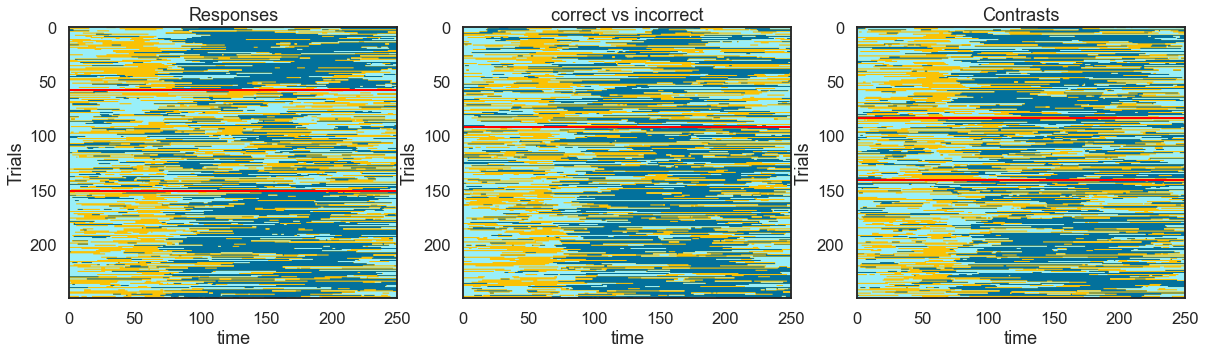

In [17]:
# %%pixie_debugger
import pickle
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_validate
clf = BernoulliNB()
fs = 100.
t, dt = np.linspace(0, 2.5, 250, retstep=True)
T = 250  # number of time bins
num_states = 3    # number of discrete states


w=6. #width parameter recommended to be >=5
freqs = np.geomspace(3, 30, num=6)
print(freqs)
s = w*fs / (2*freqs*np.pi) 

N_iters = 10
score_correct = np.zeros(39)
score_stim = np.zeros(39)
score_gonogo = np.zeros(39)
sessions = np.arange(7,8,1)
for i in sessions:
    
    # prepare data
    dat = alldat[i]
    lfp = dat_LFP[i]['lfp']
    NT = lfp.shape[1]
    half_time_wind = 20
    gocue_time = (dat['gocue']*100+50).astype(int).flatten()
    
    y=np.zeros([lfp.shape[0], 6,lfp.shape[2], lfp.shape[1]])
    for k in range(lfp.shape[0]):
        for j in range(lfp.shape[1]):
            y[k,:,:,j] = stats.zscore(np.abs(cwt(lfp[k,j,:], morlet2, s, w=w)),axis=1)
#             y[k,j,:] = butter_bandpass_filter(lfp[k,j,:], lowcut, highcut, fs, order=6)
    check_for_nans = np.isnan(y)
    print(np.sum(check_for_nans))
    print(y.shape)
    print(lfp.shape)
    lfp_b = np.reshape(y, [-1,y.shape[2]*y.shape[3]]).T
    
#     lfp_b = np.reshape(np.swapaxes(np.swapaxes(lfp_m,0,2),0,1), [-1,len(lfp_m)])
    del y
    del lfp
#     del lfp_m
#     lfp_b = np.reshape(lfp_m, [lfp_m.shape[0],-1]).T
#     lfp_n = np.swapaxes(lfp,0,2)
# #     lfp_m = np.swapaxes(lfp_n,0,1)
#     lfp_m = lfp_n
#     print(lfp_m.shape)
#     lfp_b = np.reshape(lfp_n,[-1,len(lfp)])
    print(lfp_b.shape)
    obs_dim = lfp_b.shape[1]
    
    hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")
    hmm_lls = hmm.fit(lfp_b, method="em", num_iters=N_iters)
#     plt.plot(hmm_lls, label="EM")
#     plt.xlabel("EM Iteration")
#     plt.ylabel("Log Probability")
#     plt.legend(loc="lower right")
#     plt.show()

    most_likely_states = hmm.most_likely_states(lfp_b)
#     hmm.permute(find_permutation(viz, most_likely_states))
    
    hmm_z = most_likely_states.reshape([250,-1]).T
    print(hmm_z.shape)
    filename = ['HMM_Session%d.pckl'%i]
    with open(filename[0], 'wb') as f:
        pickle.dump(hmm_z, f)
    print('HMM for Session ' + str(i) + ' has been pickled')
    
    
    choice_responses = np.sign(dat['contrast_left']-dat['contrast_right'])
#     idxs = np.where(choice_responses < 0)[0]
#     idxs = np.append(idxs, np.where(choice_responses > 0)[0])
    Y = choice_responses < 0
    X=hmm_z[:,50-half_time_wind:50+half_time_wind]
    
    clf.fit(X, Y)
    scores = cross_validate(clf, X, Y, cv=3, return_train_score=True)
    score_stim[i] = np.mean(scores['test_score'])
    print('Session ' + str(i) + ' Test score stim contrast:' + str(score_stim[i]))
    
    choice_responses = dat['response']
    idxs = np.where(choice_responses == 0)[0]
    idxs = np.append(idxs, np.where(choice_responses != 0)[0])
    Y = choice_responses == 0
    X=np.zeros(shape=(hmm_z.shape[0],40))
    for ind in range(hmm_z.shape[0]):
        X[ind,:]=hmm_z[ind,gocue_time[ind]-half_time_wind:gocue_time[ind]+half_time_wind]
    
    
    clf.fit(X, Y)
    scores = cross_validate(clf, X, Y, cv=3, return_train_score=True)
    score_gonogo[i] = np.mean(scores['test_score'])
    print('Session ' + str(i+1) + ' Test score go vs nogo:' + str(score_gonogo[i]))
    
    is_correct = np.sign(dat['response'])==np.sign(dat['contrast_left']-dat['contrast_right'])
    idxs = np.argsort(is_correct.flatten())
    Y = dat['feedback_type']
    del X
    X=hmm_z
    
    clf.fit(X, Y)
    scores = cross_validate(clf, X, Y, cv=3, return_train_score=True)
    score_correct[i] = np.mean(scores['test_score'])
    print('Session ' + str(i+1) + ' Test score correct vs incorrect:' + str(score_correct[i]))
    

    isort1 = np.argsort(dat['response'].flatten())
    
    plt.figure(figsize=(20,5))
    ax = plt.subplot(1,3,1)
    plt.imshow(hmm_z[isort1,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
    plt.xlim(0, 250)
    plt.ylabel("Trials")
    plt.xlabel("time")
    plt.plot([0, 250], [sum(dat['response']==-1), sum(dat['response']==-1)], 'r', linewidth=2)
    plt.plot([0, 250], [sum(dat['response']<=0), sum(dat['response']<=0)], 'r', linewidth=2)
    plt.title('Responses')
    
    is_correct = np.sign(dat['response'])==np.sign(dat['contrast_left']-dat['contrast_right'])
    isort2 = np.argsort(is_correct.flatten())
    
    ax = plt.subplot(1,3,2)
    plt.imshow(hmm_z[isort2,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
    plt.xlim(0, 250)
    plt.ylabel("Trials")
    plt.xlabel("time")
    plt.plot([0, 250], [sum(is_correct==0), sum(is_correct==0)], 'r', linewidth=2)
    plt.title('correct vs incorrect')
    
    vis_contrast = np.sign(dat['contrast_left']-dat['contrast_right'])
    isort3 = np.argsort(vis_contrast.flatten())
    
    ax = plt.subplot(1,3,3)
    plt.imshow(hmm_z[isort3,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
    plt.xlim(0, 250)
    plt.ylabel("Trials")
    plt.xlabel("time")
    plt.plot([0, 250], [sum(vis_contrast==-1), sum(vis_contrast==-1)], 'r', linewidth=2)
    plt.plot([0, 250], [sum(vis_contrast<=0), sum(vis_contrast<=0)], 'r', linewidth=2)    
    plt.title('Contrasts')
    
    filename = 'Session_3states '+str(i+1)+'.png'
    plt.savefig(filename, bbox_inches='tight')
    


In [39]:
sessions = np.arange(0,39,1)
for i in range(39):
    
    # prepare data
    dat = alldat[i]
    lfp = dat_LFP[i]['lfp']
    NT = lfp.shape[1]
    half_time_wind = 20
    gocue_time = (dat['gocue']*100+50).astype(int).flatten()
    
    filename = ['HMM_Session%d.pckl'%i]
    with open(filename[0], 'rb') as f:
        hmm_z = pickle.load(f)
    
    
    
    choice_responses = dat['contrast_right']
#     idxs = np.where(choice_responses < 0)[0]
#     idxs = np.append(idxs, np.where(choice_responses > 0)[0])
    Y = choice_responses == 0
    X=hmm_z[:,50-half_time_wind:50+half_time_wind]
    
    clf.fit(X, Y)
    scores = cross_validate(clf, X, Y, cv=3, return_train_score=True)
    score_stim[i] = np.mean(scores['test_score'])
    print('Session ' + str(i) + ' Test score stim contrast:' + str(score_stim[i]))
    
    choice_responses = dat['response']
    idxs = np.where(choice_responses == 0)[0]
    idxs = np.append(idxs, np.where(choice_responses != 0)[0])
    Y = choice_responses == 0
    X=np.zeros(shape=(hmm_z.shape[0],40))
    for ind in range(hmm_z.shape[0]):
        X[ind,:]=hmm_z[ind,gocue_time[ind]-half_time_wind:gocue_time[ind]+half_time_wind]
    
    
    clf.fit(X, Y)
    scores = cross_validate(clf, X, Y, cv=3, return_train_score=True)
    score_gonogo[i] = np.mean(scores['test_score'])
    print('Session ' + str(i+1) + ' Test score go vs nogo:' + str(score_gonogo[i]))
    
    is_correct = np.sign(dat['response'])==np.sign(dat['contrast_left']-dat['contrast_right'])
    idxs = np.argsort(is_correct.flatten())
    Y = dat['feedback_type']
    del X
    X=hmm_z
    
    clf.fit(X, Y)
    scores = cross_validate(clf, X, Y, cv=3, return_train_score=True)
    score_correct[i] = np.mean(scores['test_score'])
    print('Session ' + str(i+1) + ' Test score correct vs incorrect:' + str(score_correct[i]))
    

Session 0 Test score stim contrast:0.5560119979134064
Session 1 Test score go vs nogo:0.6497130933750652
Session 1 Test score correct vs incorrect:0.5983307250912885
Session 1 Test score stim contrast:0.49015108051252626
Session 2 Test score go vs nogo:0.7008032128514056
Session 2 Test score correct vs incorrect:0.5257697456492637
Session 2 Test score stim contrast:0.5
Session 3 Test score go vs nogo:0.5657894736842105
Session 3 Test score correct vs incorrect:0.530701754385965
Session 3 Test score stim contrast:0.606425702811245
Session 4 Test score go vs nogo:0.6947791164658635
Session 4 Test score correct vs incorrect:0.6867469879518072
Session 4 Test score stim contrast:0.5786647992530346
Session 5 Test score go vs nogo:0.7165732959850607
Session 5 Test score correct vs incorrect:0.6300653594771242
Session 5 Test score stim contrast:0.5447809278350516
Session 6 Test score go vs nogo:0.593213058419244
Session 6 Test score correct vs incorrect:0.5898124284077891
Session 6 Test score 

In [21]:
choice_responses = dat['response']
idxs = np.where(choice_responses == 0)[0]
idxs = np.append(idxs, np.where(choice_responses != 0)[0])
Y = choice_responses == 0
X=np.zeros(shape=(hmm_z.shape[0],40))
print(X.shape)
for ind in range(hmm_z.shape[0]):
    X[ind,:]=hmm_z[ind,gocue_time[ind]-half_time_wind:gocue_time[ind]+half_time_wind]
    
    

(214, 40)


In [ ]:
hmm_z = most_likely_states.reshape([214,-1])
print('This is what we end up with:' , hmm_z.shape)
print(hmm_z.shape)

In [ ]:
isort1 = np.argsort(dat['response'].flatten())
    
plt.figure(figsize=(20,5))
ax = plt.subplot(1,3,1)
plt.imshow(hmm_z[isort1,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, 250)
plt.ylabel("Trials")
plt.xlabel("time")
plt.plot([0, 250], [sum(dat['response']==-1), sum(dat['response']==-1)], 'r', linewidth=2)
plt.plot([0, 250], [sum(dat['response']<=0), sum(dat['response']<=0)], 'r', linewidth=2)
plt.title('Responses')

In [ ]:
hmm_z = most_likely_states.reshape([250,len(lfp_m)])
print(most_likely_states.shape)

plt.imshow(hmm_z.T, aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, 250)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

[0.64971309 0.70080321 0.56578947 0.69477912 0.7165733  0.59321306
 0.54365079 0.67995793 0.72849462 0.64205817 0.64327485 0.76188998
 0.7        0.55247607 0.51721025 0.79661405 0.5754955  0.66457023
 0.47335684 0.57416423 0.45121951 0.5990991  0.57620915 0.50793651
 0.68965517 0.61741996 0.62016807 0.6266253  0.39091916 0.53812057
 0.71729958 0.61142297 0.78497024 0.5100323  0.73963779 0.6744186
 0.77358834 0.74905774 0.59760997]
[0.59833073 0.52576975 0.53070175 0.68674699 0.63006536 0.58981243
 0.66269841 0.62029069 0.70430108 0.56152125 0.49122807 0.62412669
 0.60666667 0.59696213 0.56922793 0.6143903  0.54414414 0.68038335
 0.57101577 0.48090447 0.42721642 0.47072072 0.54261438 0.52927121
 0.54789272 0.57306968 0.50560224 0.69680851 0.53100775 0.6088948
 0.65400844 0.61142297 0.65451389 0.60135367 0.50161812 0.5620155
 0.60227687 0.67367707 0.62397661]
[0.556012   0.49015108 0.5        0.6064257  0.5786648  0.54478093
 0.54761905 0.55192197 0.48655914 0.56152125 0.61988304 0.5823

(0.0, 1.0)

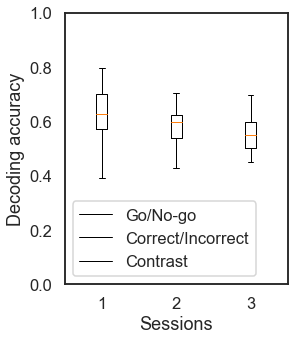

In [49]:
print(score_gonogo)
print(score_correct)
print(score_stim)

plt.figure(figsize=(4,5))
plt.boxplot(score_gonogo,positions=[1])
plt.boxplot(score_correct,positions=[2])
plt.boxplot(score_stim,positions=[3])
plt.xlabel("Sessions")
plt.ylabel("Decoding accuracy")
plt.legend(['Go/No-go', 'Correct/Incorrect', 'Contrast'])
plt.ylim([0, 1])

In [46]:
def make_similarity_matrix(hmm, data):
    num_states = hmm.K
    init_ll = hmm.log_probability(data)
    similarity = np.nan * np.ones((num_states, num_states))
    merged_hmms = np.empty((num_states, num_states), dtype=object)
    for s1 in range(num_states-1):
        for s2 in range(s1+1, num_states):
            merged_ll, merged_hmm = merge_two_states(hmm, s1, s2, data)
            similarity[s1, s2] = merged_ll - init_ll
            merged_hmms[s1, s2] = merged_hmm
            
    return similarity, merged_hmms

In [47]:
def merge_two_states(hmm, s1, s2, datas, observations="gaussian"):
    
    def collapse_and_sum_2d(arr, i, j, axis=0):
        assert axis <= 1
        out = arr.copy()
        if axis == 0:
            out[i,:] += out[j,:]
            return np.delete(out, j, axis=0)
        if axis == 1:
            out[:, i] += out[:, j]
            return np.delete(out, j, axis=1)
        
    K = hmm.K
    D = hmm.D
    assert K >= 2
    assert s1 < K
    assert s2 < K
    assert s1 != s2
    datas = datas if isinstance(datas, list) else [datas]
    inputs, masks, tags = [None], [None], [None]
    expectations = [hmm.expected_states(data, input, mask, tag)
                            for data, input, mask, tag in zip(datas, inputs, masks, tags)]
    
    # Merge expectations for 2 states
    expectations_new = []
    for (Ez, Ezz, py) in expectations:
        T_curr = Ez.shape[0]
        
        # Put merged expectations in first column
        Ez_new = collapse_and_sum_2d(Ez, s1, s2, axis=1)
        
        # Now merge Ezz
        # Ezz will have shape 1, K, K
        # so we get rid of the first dimension then add it back.
        Ezz_new = collapse_and_sum_2d(Ezz[0], s1, s2, axis=0)
        Ezz_new = collapse_and_sum_2d(Ezz_new, s1, s2, axis=1)
        Ezz_new = Ezz_new[None, :, :]
        
        expectations_new.append((Ez_new, Ezz_new, py))
    
    # Perform M-Step to get params for new hmm
    new_hmm = ssm.HMM(K-1, D, observations=observations)
    new_hmm.init_state_distn.m_step(expectations_new, datas, inputs, masks, tags)
    new_hmm.transitions.m_step(expectations_new, datas, inputs, masks, tags)
    new_hmm.observations.m_step(expectations_new, datas, inputs, masks, tags)
    
    # Evaluate log_likelihood
    expectations = [new_hmm.expected_states(data, input, mask, tag)
                    for data, input, mask, tag in zip(datas, inputs, masks, tags)]
    new_ll = new_hmm.log_prior() + sum([ll for (_, _, ll) in expectations])
    return new_ll, new_hmm

In [48]:
similarity, new_hmms = make_similarity_matrix(hmm, lfp_b)
im = plt.imshow(similarity)
plt.ylabel("state 1")
plt.xlabel("state 2")
plt.title("similarity")
plt.colorbar()

KeyboardInterrupt: 

In [8]:
lfp_brain=[]
for i in range(39):
    all_lfp = dat_LFP[i]
    no_of_lfp = len(all_lfp['brain_area_lfp'])
    print('Session ' + str(i) + ' LFPs:' + str(no_of_lfp))
    lfp_brain.append(all_lfp['brain_area_lfp'])
    print(all_lfp['brain_area_lfp'])

Session 0 LFPs:7
['ACA', 'LS', 'MOs', 'CA3', 'DG', 'SUB', 'VISp']
Session 1 LFPs:4
['CA1', 'VISl', 'POST', 'VISpm']
Session 2 LFPs:10
['CA1', 'DG', 'LP', 'MG', 'SPF', 'VISam', 'MRN', 'NB', 'POST', 'VISp']
Session 3 LFPs:13
['DG', 'LGd', 'SUB', 'TH', 'VISp', 'VPL', 'CA1', 'DG', 'TH', 'VISa', 'ACA', 'LSr', 'MOs']
Session 4 LFPs:9
['CA1', 'VISa', 'DG', 'SUB', 'ACA', 'MOs', 'OLF', 'ORB', 'PL']
Session 5 LFPs:4
['AUD', 'SSp', 'CA1', 'TH']
Session 6 LFPs:7
['CA3', 'LD', 'VPL', 'CP', 'EPd', 'PIR', 'SSp']
Session 7 LFPs:18
['ILA', 'LSr', 'MOs', 'PL', 'TT', 'CA1', 'CA3', 'DG', 'LD', 'LP', 'PO', 'VISa', 'CA1', 'DG', 'LP', 'PO', 'SUB', 'VISp']
Session 8 LFPs:13
['LSr', 'ORBm', 'PL', 'TT', 'CA1', 'CA3', 'TH', 'VISl', 'CA1', 'CA3', 'LD', 'VISam', 'VPL']
Session 9 LFPs:12
['MB', 'POST', 'SCm', 'SCsg', 'VISp', 'CA1', 'DG', 'MRN', 'POL', 'VISl', 'GPe', 'VISrl']
Session 10 LFPs:8
['LSc', 'MOp', 'PT', 'CP', 'LSr', 'MOp', 'CP', 'MOp']
Session 11 LFPs:12
['DG', 'LGd', 'SUB', 'VISp', 'ACA', 'MOs', 'PL', 'C

In [9]:
# get the brain regions of all sessions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]
nareas = len(brain_groups) 
n_sessions = len(lfp_brain) # number of sessions

bareas = []
for idx in range(n_sessions):
        
    NN = len(dat_LFP[idx]['brain_area_lfp'])
    barea = nareas * np.ones(NN, ) # last one is "other"
    for j in range(nareas):
        barea[np.isin(lfp_brain[idx], brain_groups[j])] = j # assign a number to each region
    bareas.append(barea)

sorted_by_score = np.argsort(score_gonogo)
print(sorted_by_score)

plt.figure(figsize=(20, 4))
plt.plot(score_gonogo[sorted_by_score])
plt.ylabel('Decoding Accuracy')

plt.figure(figsize=(20, 4))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
i=0

for idx in sorted_by_score:
    total=0
    for j in range(7):
        plt.bar(i,np.sum(bareas[idx]==j),bottom=total, color=colors[j])
        total += np.sum(bareas[idx]==j)
    i+=1
plt.xlabel('Sorted Sessions by Reward')
plt.ylabel('Number of subregions')
plt.title(f'Number of regions considered per session')
plt.legend(['visual cortex', 'thalamus', 'hippocampal', 'other cortex', 'midbrain', 'basal ganglia', 'cortical subplate'])

NameError: name 'score_gonogo' is not defined

In [ ]:
print(bareas[0])